In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi_stacking.utils as utils
import sbi_stacking.stacking as stacking
import sbi_stacking.sbibm as ssbibm

2023-10-17 00:00:05.201480: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 00:00:05.247141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device = "cuda:0"
alpha = 0.1

tasks = ["two_moons_whist", "slcp", "sir", "simbig"]

Stacking for task: two_moons_whist
two_moons_whist torch.Size([50, 1000, 2, 2]) torch.Size([50, 1000, 2, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final loss: tensor(0.7927)


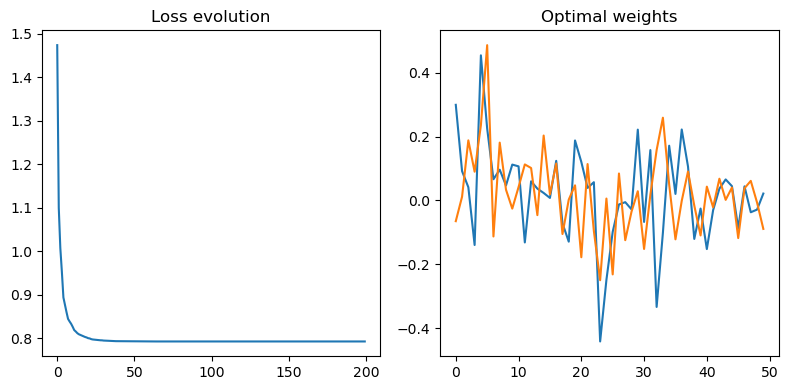

Coverage best model (abs error) 3.250005841255188 %
Coverage unif (abs error) 5.250006914138794 %
Coverage stacked (abs error) 2.749994397163391 %
Stacking for task: slcp
slcp torch.Size([50, 1000, 5, 2]) torch.Size([50, 1000, 5, 2]) torch.Size([1000, 5]) torch.Size([1000, 5])
Final loss: tensor(3.7131)


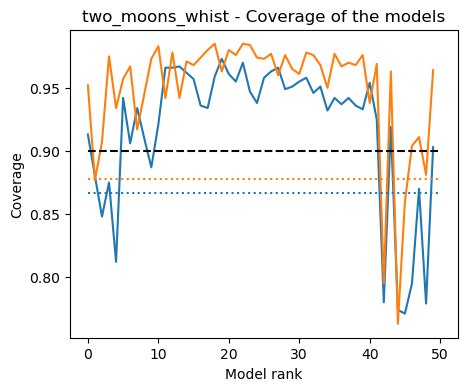

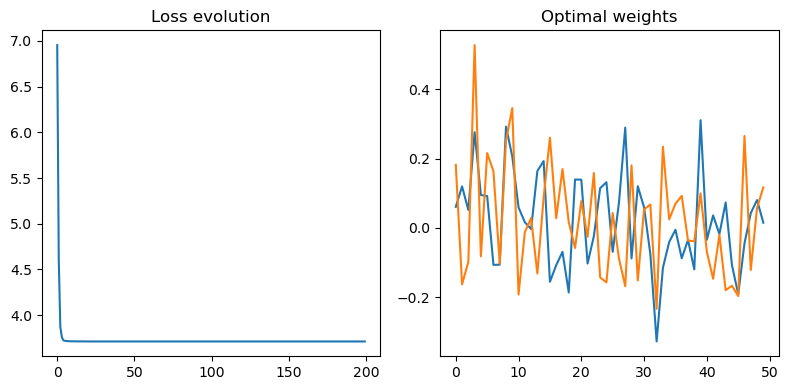

Coverage best model (abs error) 3.7599921226501465 %
Coverage unif (abs error) 5.179994180798531 %
Coverage stacked (abs error) 1.1599993333220482 %
Stacking for task: sir
sir torch.Size([50, 1000, 2, 2]) torch.Size([50, 1000, 2, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final loss: tensor(0.0640)


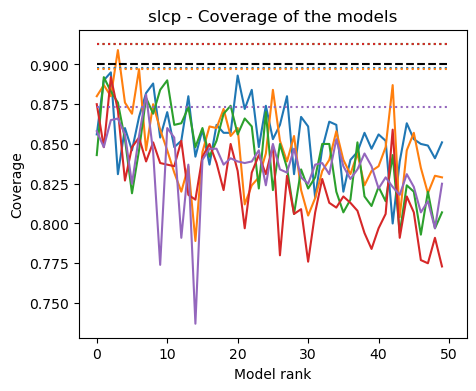

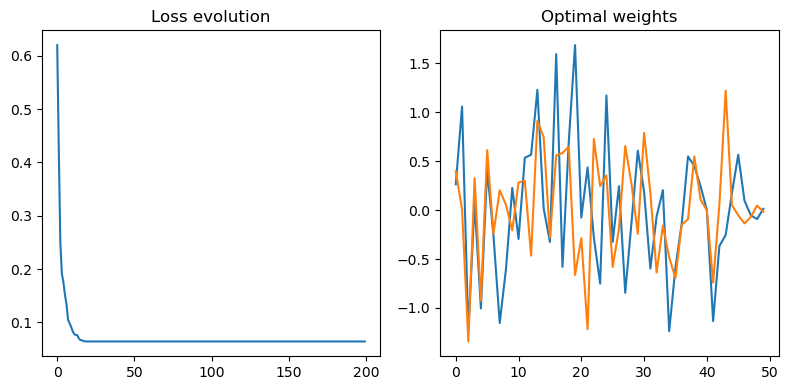

Coverage best model (abs error) 2.9000073671340942 %
Coverage unif (abs error) 9.35000479221344 %
Coverage stacked (abs error) 1.549994945526123 %
Stacking for task: simbig
simbig torch.Size([100, 1000, 14, 2]) torch.Size([100, 1000, 14, 2]) torch.Size([1000, 14]) torch.Size([1000, 14])
Final loss: tensor(0.7106)


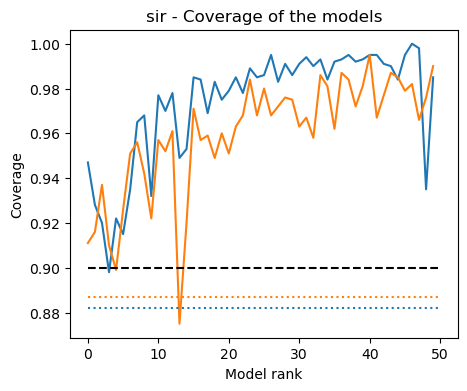

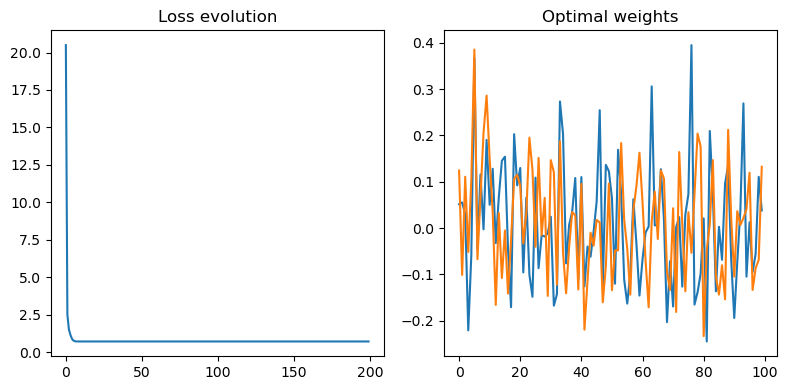

Coverage best model (abs error) 6.078567355871201 %
Coverage unif (abs error) 5.849995836615562 %
Coverage stacked (abs error) 4.264280945062637 %


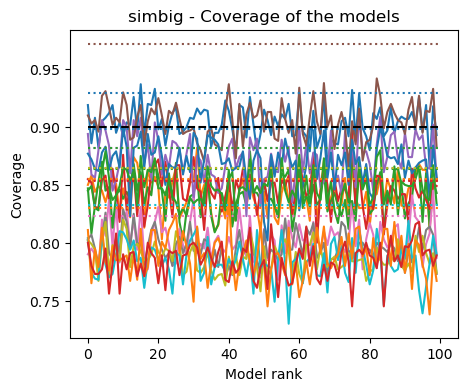

In [4]:
for task in tasks:
    print("Stacking for task:", task)

    if task != "simbig":
        intervals_train = utils.get_stats(task, "intervals")
        thetas_train = utils.get_stats(task, "theta_test")
        intervals_test = utils.get_stats(task, "intervals_v2")
        thetas_test = utils.get_stats(task, "theta_test_v2")
    else:
        
        intervals = utils.get_stats(task, "intervals")
        thetas = utils.get_stats(task, "theta_test")
        randindices = torch.randperm(intervals.shape[1])

        intervals_train = intervals[:, randindices[:1000]]
        thetas_train = thetas[randindices[:1000]]
        intervals_test = intervals[:, randindices[1000:]]
        thetas_test = thetas[randindices[1000:]]

    print(task, intervals_train.shape, intervals_test.shape, thetas_train.shape, thetas_test.shape)
    nb_models = intervals_train.shape[0]

    n_it = 50

    opt_weights, losses = stacking.stacking_invervals(intervals_train,
                                                    thetas_train,
                                                    alpha=alpha)
    print("Final loss:", losses[-1])

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].plot(losses)
    axs[0].set_title("Loss evolution")
    axs[1].plot(opt_weights.reshape(-1, 2).cpu())
    axs[1].set_title("Optimal weights")
    plt.tight_layout()
    plt.show()

    # Compute intervals mixture for test
    mintervals_test = stacking.mixture_interval(intervals_test, opt_weights)
    munif_intervals_test = stacking.mixture_interval(intervals_test, torch.ones_like(opt_weights)/nb_models)

    # Compute coverage
    coverage_per_model = torch.zeros((nb_models, thetas_test.shape[-1]), device=device)
    coverage_stacking = torch.zeros(thetas_test.shape[-1], device=device)
    coverage_unif = torch.zeros(thetas_test.shape[-1], device=device)
    for i in range(nb_models):
        coverage_per_model[i] = ((thetas_test >= intervals_test[i, :, :, 0]) & (thetas_test <= intervals_test[i, :, :, 1])).float().mean(dim=0)
    coverage_stacking = ((thetas_test >= mintervals_test[:, :, 0]) & (thetas_test <= mintervals_test[:, :, 1])).float().mean(dim=0)
    coverage_unif = ((thetas_test >= munif_intervals_test[:, :, 0]) & (thetas_test <= munif_intervals_test[:, :, 1])).float().mean(dim=0)

    # Plot of the evolution of the log probabilities and optimal weights
    plt.figure(figsize=(5, 4))
    plt.plot(coverage_per_model.cpu())
    for i in range(coverage_per_model.shape[-1]):
        plt.hlines(coverage_stacking.cpu()[i], 0, nb_models, color=f"C{i}", linestyle="dotted")
    plt.hlines(1-alpha, 0, nb_models, color="black", linestyle="--")
    plt.ylabel("Coverage")
    plt.xlabel("Model rank")
    plt.title(f"{task} - Coverage of the models")

    print("Coverage best model (abs error)", torch.abs(coverage_per_model[0] - (1-alpha)).cpu().numpy().mean()*100, "%")
    print("Coverage unif (abs error)", torch.abs(coverage_unif - (1-alpha)).cpu().numpy().mean()*100, "%")
    print("Coverage stacked (abs error)", torch.abs(coverage_stacking- (1-alpha)).cpu().numpy().mean()*100, "%")